<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="30%" />

# SPAM detector:
## Spam was the main challenge for AT&T, because it had to manually flag spam for a while. So it looked for a way to automatically identify spam.

## The goal is to make an automated spam identifier, so it needs to develop a model that can spot spam in the message content.

<h1> Import librairies <h1>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import spacy
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,  ConfusionMatrixDisplay, RocCurveDisplay, classification_report
import sklearn
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
import os
import io


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## I. Exploring the data :

#### Upload Data :

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fullstuck_3/Deep Learning/Projet deep_learning/spam.csv", encoding='ISO-8859-1', error_bad_lines=False)

<ipython-input-3-2baf2f44c1cc>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fullstuck_3/Deep Learning/Projet deep_learning/spam.csv", encoding='ISO-8859-1', error_bad_lines=False)


#### Overview and statistics :

In [4]:
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
display(df.describe(include='all'))
print()

print("Percentage of missing values: ")
display(100 * df.isnull().mean())

Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

Three columns are useless because they have almost only missing values (Unnamed: 2, Unnamed: 3, Unnamed: 4). The other two columns are the message (v2) and the tag assigned to the message (spam for spam and ham for normal messages). We can be glad that there are no missing values in these two useful columns

#### Data Cleaning and Display :

In [5]:
df = df.astype('string')
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])
df = df.rename(columns={'v1': 'label', 'v2' : 'message'})

In [6]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


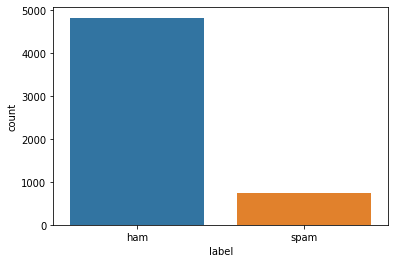

In [7]:
sns.countplot(x = df['label'])
plt.show()

A positive point is that our feature columns (message) are uniform, composed only of text. We will therefore have to apply preprocessing on the data to be able to use them with our model.

In [8]:
fig_target =  px.pie(df, values= df['label'].value_counts().values, names=df['label'].value_counts().index, title = 'Label proportion', width = 600, height = 400)
fig_target.update(layout=dict(title=dict(x=0.5)))
fig_target.show()

The data is skewed (imbalanced), but it should still be enough to obtain relevant results.

#### II. Preprocessing:

<h4> Keep only the alpha numeric caracters <h4>

In [9]:
df["message_clean"] = df["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["message_clean"] = df["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df.head()

,label,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don't think he goes to usf he lives arou...


<h4> Lemmatization <h4>

In [10]:
nlp = spacy.load("en_core_web_sm")
df["message_clean"] = df["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
mask0 = df.message_clean.apply(lambda x: type(x)==str)
df = df[mask0]
mask1 = df['message_clean'].isna()==False
df = df[mask1]
df.head()

,label,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


<h4> Tokenization <h4>

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() # instanciate the tokenizer
tokenizer.fit_on_texts(df.message_clean)
df["message_encoded"] = tokenizer.texts_to_sequences(df.message_clean)

In [12]:
df.head()

,label,message,message_clean,message_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[3605, 229, 446, 463, 941, 31, 49, 203, 942, 7..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[7, 194, 464, 288, 1, 1456]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 299, 2, 532, 661, 29, 1457, 848, 423, 145..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[1, 124, 149, 2358, 1, 78]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[704, 19, 662, 128]"


<h4> Padding <h4>

In [13]:
message_pad = tf.keras.preprocessing.sequence.pad_sequences(df["message_encoded"], padding="post")
message_pad

array([[3605,  229,  446, ...,    0,    0,    0],
       [   7,  194,  464, ...,    0,    0,    0],
       [  10,  299,    2, ...,    0,    0,    0],
       ...,
       [8186,  936, 8187, ...,    0,    0,    0],
       [ 112, 8188, 1597, ...,    0,    0,    0],
       [2078,  318,    0, ...,    0,    0,    0]], dtype=int32)

In [14]:
vocab_size = len(tokenizer.word_index)
print('Vocabulary size :',vocab_size)
df.head()

Vocabulary size : 8188


,label,message,message_clean,message_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[3605, 229, 446, 463, 941, 31, 49, 203, 942, 7..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[7, 194, 464, 288, 1, 1456]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 299, 2, 532, 661, 29, 1457, 848, 423, 145..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[1, 124, 149, 2358, 1, 78]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[704, 19, 662, 128]"


<h4> Train/Test split <h4>

In [15]:
xtrain, xval, ytrain, yval = train_test_split(message_pad,df.label, test_size=0.3)

<h4> Label encoding --> text to numeric <h4>

In [16]:
encoder = LabelEncoder()
ytrain = encoder.fit_transform(ytrain)
yval = encoder.transform(yval)

<h4> Batch construction and shuffle <h4>

In [17]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

<h2> III. Model construction <h2>

#### A. Establishing a baseline

In [18]:
lr = LogisticRegression(max_iter=1500)
lr.fit(xtrain,ytrain)
pred_logreg = lr.predict(xval)

print(classification_report(yval,pred_logreg))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94      1455
           1       0.62      0.23      0.33       217

    accuracy                           0.88      1672
   macro avg       0.76      0.60      0.63      1672
weighted avg       0.86      0.88      0.86      1672



In [19]:
nb = MultinomialNB()
nb.fit(xtrain,ytrain)
nb_pred = nb.predict(xval)

print(classification_report(yval,nb_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      1455
           1       0.52      0.77      0.62       217

    accuracy                           0.88      1672
   macro avg       0.74      0.83      0.77      1672
weighted avg       0.91      0.88      0.89      1672



Logistic regression and Multinomial Naive Bayes are two methods that can be used to identify spam emails. Logistic regression is a basic method that can identify a few spam emails, while Multinomial Naive Bayes can identify more spam emails but also misidentifies more legitimate emails. However, both methods are not very useful in a production environment but can provide a good starting point

#### B. Simple embedding :

In [20]:
simple_model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size + 1, 8, input_shape=[message_pad.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [21]:
optimizer= tf.keras.optimizers.Adam()

simple_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [22]:
history = simple_model.fit(train_batch, 
                    epochs=40, 
                    validation_data=val_batch)

Epoch 1/40
61/61 [==============================] - 16s 155ms/step - loss: 0.6304 - binary_accuracy: 0.8395 - val_loss: 0.5567 - val_binary_accuracy: 0.8702
Epoch 2/40
61/61 [==============================] - 5s 75ms/step - loss: 0.4910 - binary_accuracy: 0.8641 - val_loss: 0.4209 - val_binary_accuracy: 0.8702
Epoch 3/40
61/61 [==============================] - 5s 75ms/step - loss: 0.3919 - binary_accuracy: 0.8641 - val_loss: 0.3606 - val_binary_accuracy: 0.8702
Epoch 4/40
61/61 [==============================] - 2s 33ms/step - loss: 0.3600 - binary_accuracy: 0.8641 - val_loss: 0.3455 - val_binary_accuracy: 0.8702
Epoch 5/40
61/61 [==============================] - 3s 46ms/step - loss: 0.3497 - binary_accuracy: 0.8641 - val_loss: 0.3378 - val_binary_accuracy: 0.8702
Epoch 6/40
61/61 [==============================] - 3s 42ms/step - loss: 0.3407 - binary_accuracy: 0.8641 - val_loss: 0.3295 - val_binary_accuracy: 0.8702
Epoch 7/40
61/61 [==============================] - 2s 27ms/step - l

In [23]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=history.history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy' )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()
plt.show()

In [24]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history["binary_accuracy"],
                    mode='lines',
                    name='Training accuracy'))
fig.add_trace(go.Scatter(y=history.history["val_binary_accuracy"],
                    mode='lines',
                    name='Validation accuracy'))
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Accuracy' )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()
plt.show()

The baseline model’s accuracy improved rapidly, reaching an accuracy score of around 0.983 before plateauing. Let’s now check the F1-score since we suspected high false negatives due to the imbalance

In [25]:
Y_train_pred = simple_model.predict(xtrain)
Y_test_pred = simple_model.predict(xval)
Y_train_pred = Y_train_pred.reshape(-1)
Y_test_pred = Y_test_pred.reshape(-1)
Y_train_pred= pd.DataFrame(Y_train_pred)
Y_test_pred= pd.DataFrame(Y_test_pred)
Y_train_pred = round(Y_train_pred)
Y_test_pred = round(Y_test_pred)
print("f1-score on training set : ", f1_score(ytrain, Y_train_pred))
print("f1-score on test set : ", f1_score(yval, Y_test_pred))

53/53 [==============================] - 0s 2ms/step
f1-score on training set :  0.9885496183206107
f1-score on test set :  0.9468599033816425


Confusion Matrix for the train set:


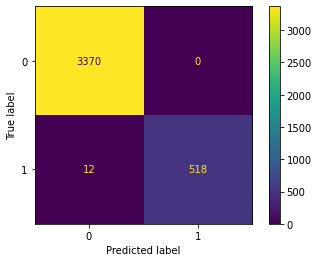

Confusion Matrix for the test set:


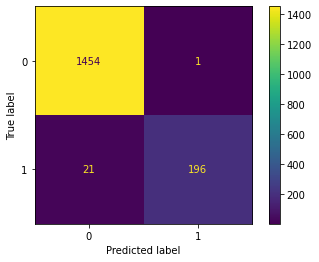

In [26]:
Confusion_matrix_train = confusion_matrix(ytrain,Y_train_pred)
ConfusionMatrixDisplay(Confusion_matrix_train).plot()
print('Confusion Matrix for the train set:')
plt.show()
Confusion_matrix_test = confusion_matrix(yval,Y_test_pred)
print('Confusion Matrix for the test set:')
ConfusionMatrixDisplay(Confusion_matrix_test).plot()
plt.show()

In [27]:
predictions_1 = simple_model.predict(xval)
predictions_1 = predictions_1.reshape(-1)
results_1 = pd.DataFrame({'test':yval,'pred':predictions_1})
results_1['pred'] = round(results_1['pred'])
print(classification_report(results_1.test,results_1.pred))

53/53 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1455
           1       0.99      0.90      0.95       217

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672



#### C. LSTM model :

In [45]:
LSTM_model = tf.keras.Sequential([
    # Couche d'Input Word Embedding
    tf.keras.layers.Embedding(vocab_size + 1, 300, input_shape=[message_pad.shape[1],],name="embedding"),
    # Couche LSTM
    tf.keras.layers.LSTM(64,dropout=0.2, recurrent_dropout=0.2),
    # Couche Dense classique
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [46]:
LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 300)           2456700   
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,550,205
Trainable params: 2,550,205
Non-trainable params: 0
_________________________________________________________________


In [47]:
optimizer= tf.keras.optimizers.Adam(learning_rate = 0.00007)

LSTM_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [48]:
history = LSTM_model.fit(train_batch, 
                    epochs=40, 
                    validation_data=val_batch)

Epoch 1/40
61/61 [==============================] - 28s 400ms/step - loss: 0.6139 - binary_accuracy: 0.7838 - val_loss: 0.4965 - val_binary_accuracy: 0.8702
Epoch 2/40
61/61 [==============================] - 20s 334ms/step - loss: 0.4200 - binary_accuracy: 0.8641 - val_loss: 0.3863 - val_binary_accuracy: 0.8702
Epoch 3/40
61/61 [==============================] - 20s 319ms/step - loss: 0.3975 - binary_accuracy: 0.8641 - val_loss: 0.3866 - val_binary_accuracy: 0.8702
Epoch 4/40
61/61 [==============================] - 19s 317ms/step - loss: 0.3973 - binary_accuracy: 0.8641 - val_loss: 0.3855 - val_binary_accuracy: 0.8702
Epoch 5/40
61/61 [==============================] - 18s 297ms/step - loss: 0.3979 - binary_accuracy: 0.8641 - val_loss: 0.3849 - val_binary_accuracy: 0.8702
Epoch 6/40
61/61 [==============================] - 18s 295ms/step - loss: 0.3972 - binary_accuracy: 0.8641 - val_loss: 0.3845 - val_binary_accuracy: 0.8702
Epoch 7/40
61/61 [==============================] - 19s 30

The model trains really fast and additional epochs don’t improve performance; it’s already very high!

In [49]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=history.history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy' )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()
plt.show()

In [50]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history["binary_accuracy"],
                    mode='lines',
                    name='Training accuracy'))
fig.add_trace(go.Scatter(y=history.history["val_binary_accuracy"],
                    mode='lines',
                    name='Validation accuracy'))
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Accuracy' )
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()
plt.show()

In [51]:
Y_train_pred = LSTM_model.predict(xtrain)
Y_test_pred = LSTM_model.predict(xval)
Y_train_pred = Y_train_pred.reshape(-1)
Y_test_pred = Y_test_pred.reshape(-1)
Y_train_pred= pd.DataFrame(Y_train_pred)
Y_test_pred= pd.DataFrame(Y_test_pred)
Y_train_pred = round(Y_train_pred)
Y_test_pred = round(Y_test_pred)
print("f1-score on training set : ", f1_score(ytrain, Y_train_pred))
print("f1-score on test set : ", f1_score(yval, Y_test_pred))

53/53 [==============================] - 1s 28ms/step
f1-score on training set :  0.977948226270374
f1-score on test set :  0.9277389277389277


Confusion Matrix for the train set:


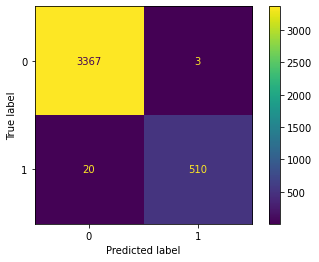

Confusion Matrix for the test set:


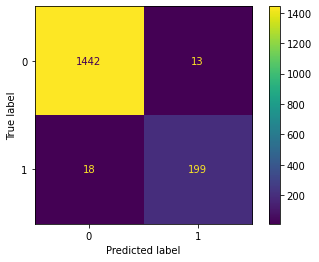

In [52]:
Confusion_matrix_train = confusion_matrix(ytrain,Y_train_pred)
ConfusionMatrixDisplay(Confusion_matrix_train).plot()
print('Confusion Matrix for the train set:')
plt.show()
Confusion_matrix_test = confusion_matrix(yval,Y_test_pred)
print('Confusion Matrix for the test set:')
ConfusionMatrixDisplay(Confusion_matrix_test).plot()
plt.show()

In [53]:
predictions_2 = LSTM_model.predict(xval)
predictions_2 = predictions_2.reshape(-1)
results_2 = pd.DataFrame({'test':yval,'pred':predictions_2})
results_2['pred'] = round(results_2['pred'])
print(classification_report(results_2.test,results_2.pred))

53/53 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1455
           1       0.94      0.92      0.93       217

    accuracy                           0.98      1672
   macro avg       0.96      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



#  IV. Transfer Learning:

##Roberta :

To enhance our already good results, we’ve been exploring transfer learning using a model trained on billions of observations. We discovered the ideal model based on the RoBERTa base model, which is pre-trained on the English language. The one we found, roberta-base-finetuned-sms-spam-detection, is a fine-tuned version trained on the sms_spam dataset to recognize spam in SMS messages. More information can be found on the Hugging Face website : https://huggingface.co/mariagrandury/roberta-base-finetuned-sms-spam-detection

In [54]:
df["message_clean"] = df["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["message_clean"] = df["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
xtrain0, xval0, ytrain0, yval0 = train_test_split(df.message_clean,df.label, test_size=0.2, stratify=df.label)
ytrain0 = encoder.fit_transform(ytrain0)
yval0 = encoder.transform(yval0)

In [55]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('mariagrandury/roberta-base-finetuned-sms-spam-detection')
model = TFAutoModelForSequenceClassification.from_pretrained('mariagrandury/roberta-base-finetuned-sms-spam-detection',from_pt=True)
# Reference : https://huggingface.co/mariagrandury/roberta-base-finetuned-sms-spam-detection

encoded_input = tokenizer(list(xval0), return_tensors='tf', padding = True)
output = model(encoded_input)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [57]:
output

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(1115, 2), dtype=float32, numpy=
array([[ 4.487665 , -4.1656556],
       [ 4.133698 , -3.9021735],
       [ 4.3330045, -4.082405 ],
       ...,
       [ 4.3198853, -4.108956 ],
       [ 4.436261 , -4.205074 ],
       [ 4.3205833, -4.0696554]], dtype=float32)>, hidden_states=None, attentions=None)

In [58]:
output_binary = [np.argmax(x) for x in output[0]]
print("accuracy on test set : ", accuracy_score(yval0, output_binary))
print("f1-score on test set : ", f1_score(yval0, output_binary))

accuracy on test set :  0.9973094170403587
f1-score on test set :  0.9898989898989898


Confusion Matrix for the test set:


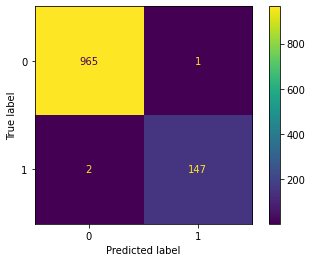

In [59]:
Confusion_matrix_test = confusion_matrix(yval0, output_binary)
print('Confusion Matrix for the test set:')
ConfusionMatrixDisplay(Confusion_matrix_test).plot()
plt.show()

In [60]:
roberta_res = [np.argmax(x) for x in output[0]]
results_3 = pd.DataFrame({'test':yval0,'pred':roberta_res})
print(classification_report(results_3.test,results_3.pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       966
           1       0.99      0.99      0.99       149

    accuracy                           1.00      1115
   macro avg       1.00      0.99      0.99      1115
weighted avg       1.00      1.00      1.00      1115



#### VI. Conclusion :

In [61]:
baseline_model_results = classification_report(yval,pred_logreg, output_dict=True)
model_nb_results = classification_report(yval,nb_pred, output_dict=True)
model_1_results = classification_report(results_1.test,results_1.pred, output_dict=True)
model_2_results = classification_report(results_2.test,results_2.pred, output_dict=True)
model_3_results = classification_report(results_3.test,results_3.pred, output_dict=True)
  
total_results = pd.DataFrame({'Logistic Regression':baseline_model_results['1'],
                            'Multinomial Naive Bayes':model_nb_results['1'],
                             'Simple embedding':model_1_results['1'],
                             'LSTM Model':model_2_results['1'],
                             'RoBERTa spam detection':model_3_results['1']}).transpose()

accuracy = [accuracy_score(yval, pred_logreg),
            accuracy_score(yval, nb_pred),
            accuracy_score(results_1.test, results_1.pred),
            accuracy_score(results_2.test, results_2.pred),
            accuracy_score(results_3.test, results_3.pred)]
total_results['Accuracy'] = accuracy

total_results.drop(columns=['support'])
                             


,precision,recall,f1-score,Accuracy
Logistic Regression,0.620253,0.225806,0.331081,0.881579
Multinomial Naive Bayes,0.516923,0.774194,0.619926,0.876794
Simple embedding,0.994924,0.903226,0.946860,0.986842
LSTM Model,0.938679,0.917051,0.927739,0.981459
RoBERTa spam detection,0.993243,0.986577,0.989899,0.997309


RoBERTa, which is a more advanced model that has undergone extensive training, proved to be the most effective at filtering spam messages as despite the imbalance of the dataset and we have been able to reach an accuracy of 0.99% . <br> 
To improve further, we could combine our results with a list of phone numbers already identified as spam-senders to eliminate the few remaining spams, and/or try to identify other behavioral patterns not contained in the text